In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print("Training Data Shape:", train_images.shape)
print("Testing Data Shape:", test_images.shape)

# Rescale images from [0, 255] to [0.0, 1.0]
train_data_clean = train_images / 255.0
test_data_clean = test_images / 255.0

print("Unique Train Labels:", np.unique(train_labels))
print("Unique Test Labels:", np.unique(test_labels))

Training Data Shape: (60000, 28, 28)
Testing Data Shape: (10000, 28, 28)
Unique Train Labels: [0 1 2 3 4 5 6 7 8 9]
Unique Test Labels: [0 1 2 3 4 5 6 7 8 9]


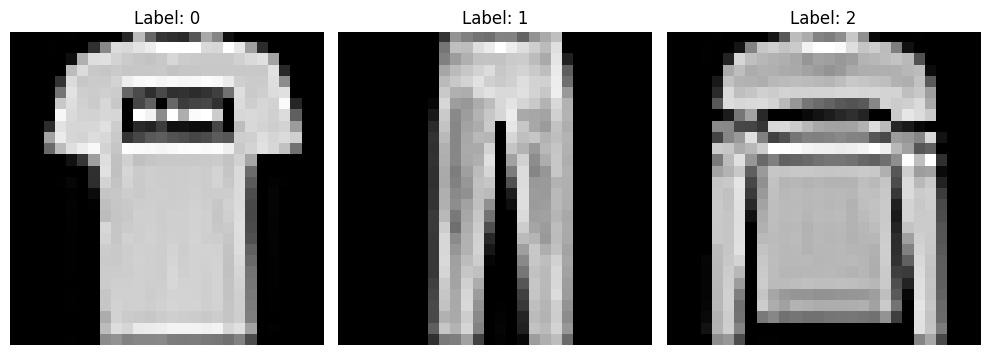

In [ ]:
# Function to display sample images
def display_images(images, labels, num_images=3):
    selected_classes = [0, 1, 2]

    # Empty lists to store images and labels
    selected_images = []
    selected_labels = []

    # Select one image per selected class
    for class_label in selected_classes:
        class_indices = np.where(labels == class_label)[0]
        selected_images.append(images[class_indices[0]])  # Choose first image from the class
        selected_labels.append(labels[class_indices[0]])  # Store the corresponding label

    # Convert the lists back to arrays
    selected_images = np.array(selected_images)
    selected_labels = np.array(selected_labels)

    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 4))
    for i, ax in enumerate(axes):
        ax.imshow(selected_images[i].squeeze(), cmap='gray')  # Remove the channel dimension
        ax.set_title(f'Label: {selected_labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Show sample data from the clean dataset
display_images(train_data_clean, train_labels, num_images=3)

Noisy Training Data Shape: (60000, 28, 28)
Noisy Testing Data Shape: (10000, 28, 28)


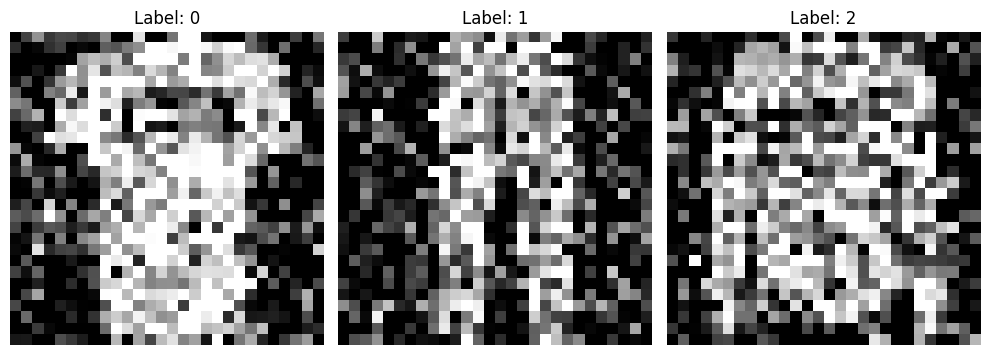

In [ ]:
# Function for adding noise to the images
def add_gaussian_noise(images, mean=0.0, severity=1):
    severity_levels = [0.08, 0.12, 0.18, 0.26, 0.38]
    stddev = severity_levels[severity - 1]  # Get stddev based on severity
    noise = np.random.normal(mean, stddev, images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0.0, 1.0)  # Ensure pixel values are in [0.0, 1.0]
    return noisy_images

train_data_noisy = add_gaussian_noise(train_data_clean, severity=5)
test_data_noisy = add_gaussian_noise(test_data_clean, severity=5)

print("Noisy Training Data Shape:", train_data_noisy.shape)
print("Noisy Testing Data Shape:", test_data_noisy.shape)

display_images(train_data_noisy, train_labels, num_images=3)

In [ ]:
# Function for creating CCNN model for full size images
def create_model():
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(tf.keras.layers.Dropout(0.5))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())

    # Block 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))  # 10 classes in Fashion MNIST

    model.summary()

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
# Create the clean model for the clean dataset
clean_model = create_model()
history_clean = clean_model.fit(train_data_clean,
                                train_labels,
                                epochs=10,
                                batch_size=128,
                                validation_data=(test_data_clean, test_labels)
                                )

# Evaluate on clean test data
test_loss_clean, test_acc_clean = clean_model.evaluate(test_data_clean, test_labels, verbose=2)
print(f"Clean Data - Test Accuracy: {test_acc_clean:.4f}, Test Loss: {test_loss_clean:.4f}")
print(f"Clean Data - Training Accuracy: {history_clean.history['accuracy'][-1]:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 9, 9, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 721,354 (2.75 MB)

 Trainable params: 721,034 (2.75 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.7360 - loss: 0.7929 - val_accuracy: 0.7880 - val_loss: 0.5754
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8556 - loss: 0.4027 - val_accuracy: 0.8792 - val_loss: 0.3228
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8742 - loss: 0.3467 - val_accuracy: 0.8911 - val_loss: 0.3090
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8867 - loss: 0.3133 - val_accuracy: 0.8861 - val_loss: 0.3360
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8983 - loss: 0.2783 - val_accuracy: 0.9073 - val_loss: 0.2648
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9028 - loss: 0.2675 - val_accuracy: 0.9097 - val_loss: 0.2561
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9063 - loss: 0.2547 - val_accuracy: 0.9134 - val_loss: 0.2479
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9101 - loss: 0.2395 - val_accuracy:

In [ ]:
# Utility to display training and validation curves
def plot_metrics(history, metric_name, title, ylim=1, xlim=10):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.xlim(0,xlim)
  plt.plot(history.history[metric_name],color='blue',label='Train')
  plt.plot(history.history['val_' + metric_name],color='green',label='Validation')
  plt.legend(loc='lower right')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")

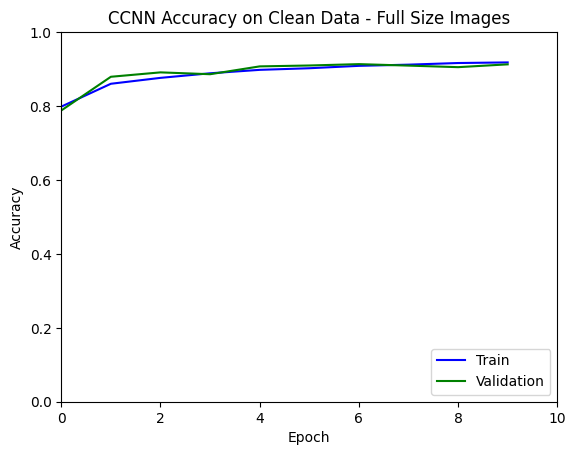

In [ ]:
plot_metrics(history_clean, "accuracy", "CCNN Accuracy on Clean Data - Full Size Images")

In [ ]:
# Create another model for noisy dataset
noisy_model = create_model()
history_noisy = noisy_model.fit(train_data_noisy,
                                train_labels,
                                epochs=10,
                                batch_size=128,
                                validation_data=(test_data_noisy, test_labels)
                                )

# Evaluate on noisy test data
test_loss_noisy, test_acc_noisy = noisy_model.evaluate(test_data_noisy, test_labels, verbose=2)
print(f"Noisy Data - Test Accuracy: {test_acc_noisy:.4f}, Test Loss: {test_loss_noisy:.4f}")
print(f"Noisy Data - Training Accuracy: {history_noisy.history['accuracy'][-1]:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 9, 9, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 9, 9, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 721,354 (2.75 MB)

 Trainable params: 721,034 (2.75 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6368 - loss: 1.0764 - val_accuracy: 0.6744 - val_loss: 0.8483
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7720 - loss: 0.6081 - val_accuracy: 0.8102 - val_loss: 0.5261
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8003 - loss: 0.5387 - val_accuracy: 0.8233 - val_loss: 0.4830
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8093 - loss: 0.5068 - val_accuracy: 0.8298 - val_loss: 0.4709
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8239 - loss: 0.4708 - val_accuracy: 0.8326 - val_loss: 0.4590
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8294 - loss: 0.4511 - val_accuracy: 0.8365 - val_loss: 0.4644
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8408 - loss: 0.4284 - val_accuracy: 0.8359 - val_loss: 0.4590
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8448 - loss: 0.4080 - val_accuracy: 

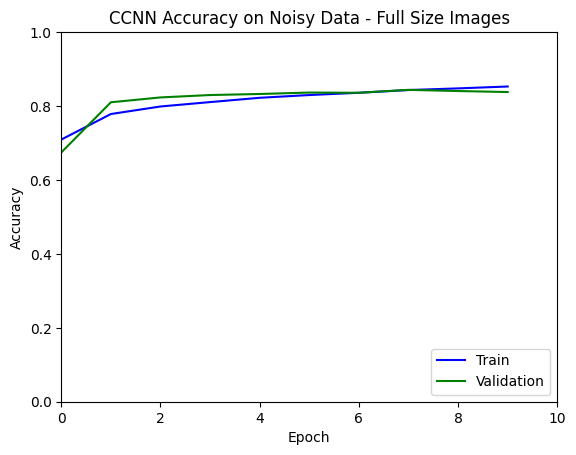

In [ ]:
plot_metrics(history_noisy, "accuracy", "CCNN Accuracy on Noisy Data - Full Size Images")

In [ ]:
# Extract true labels for other performance metrics
y_true = test_labels

# Clean predictions
y_pred_clean = clean_model.predict(test_data_clean)
y_pred_clean = np.argmax(y_pred_clean, axis=-1)  # Convert probabilities to class indices

# Noisy predictions
y_pred_noisy = noisy_model.predict(test_data_noisy)
y_pred_noisy = np.argmax(y_pred_noisy, axis=-1)  # Convert probabilities to class indices

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Clean metrics
accuracy_clean = accuracy_score(y_true, y_pred_clean)
precision_clean = precision_score(y_true, y_pred_clean, average='weighted')
recall_clean = recall_score(y_true, y_pred_clean, average='weighted')
f1_clean = f1_score(y_true, y_pred_clean, average='weighted')

print("\nClean Data Metrics:")
print(f"Accuracy: {accuracy_clean:.4f}")
print(f"Precision: {precision_clean:.4f}")
print(f"Recall: {recall_clean:.4f}")
print(f"F1 Score: {f1_clean:.4f}")


Clean Data Metrics:
Accuracy: 0.9128
Precision: 0.9130
Recall: 0.9128
F1 Score: 0.9124


In [ ]:
# Noisy metrics
accuracy_noisy = accuracy_score(y_true, y_pred_noisy)
precision_noisy = precision_score(y_true, y_pred_noisy, average='weighted')
recall_noisy = recall_score(y_true, y_pred_noisy, average='weighted')
f1_noisy = f1_score(y_true, y_pred_noisy, average='weighted')

print("\nNoisy Data Metrics:")
print(f"Accuracy: {accuracy_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall: {recall_noisy:.4f}")
print(f"F1 Score: {f1_noisy:.4f}")


Noisy Data Metrics:
Accuracy: 0.8379
Precision: 0.8402
Recall: 0.8379
F1 Score: 0.8375


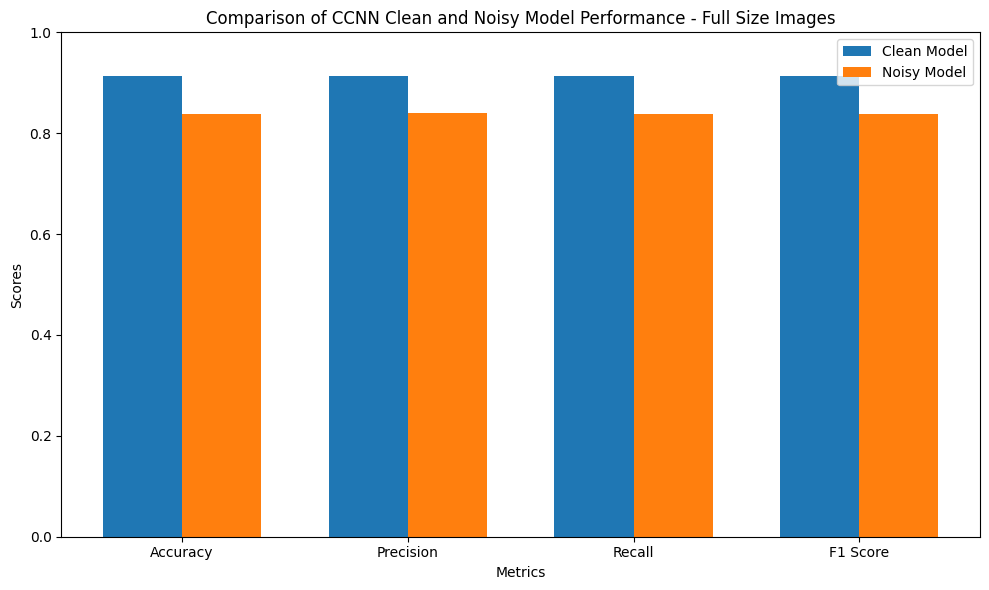

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
clean_values = [accuracy_clean, precision_clean, recall_clean, f1_clean]
noisy_values = [accuracy_noisy, precision_noisy, recall_noisy, f1_noisy]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, clean_values, width, label='Clean Model')
rects2 = ax.bar(x + width/2, noisy_values, width, label='Noisy Model')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of CCNN Clean and Noisy Model Performance - Full Size Images')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)  # Fixed y-axis range from 0 to 1
plt.tight_layout()
plt.show()



---
In the next section we perform multiclass classification on images that are scaled down to 4x4 pixels to show a fair comparison with the image sizes provided to the QCNN. Subsets of the data are also taken in the same random sampling method used in the QCNN.


---




In [ ]:
# Number of examples that will be in the subsets,
# Maintaining the original 6:1 ratio of train to test data
num_train = 6000
num_test = 1000

# Number of examples per class (10 classes)
num_train_per_class = num_train // 10
num_test_per_class = num_test // 10

train_images_subset = []
train_labels_subset = []
test_images_subset = []
test_labels_subset = []

# Iterate over each class and sample equally
for i in range(10):
    class_indices_train = np.where(train_labels == i)[0]
    class_indices_test = np.where(test_labels == i)[0]

    # Randomly sample some images per class
    sampled_train_indices = np.random.choice(class_indices_train, num_train_per_class, replace=False)
    sampled_test_indices = np.random.choice(class_indices_test, num_test_per_class, replace=False)

    # Add them to the list
    train_images_subset.append(train_data_clean[sampled_train_indices])
    train_labels_subset.append(train_labels[sampled_train_indices])
    test_images_subset.append(test_data_clean[sampled_test_indices])
    test_labels_subset.append(test_labels[sampled_test_indices])

# Convert lists to arrays
train_images_subset = np.concatenate(train_images_subset)
train_labels_subset = np.concatenate(train_labels_subset)
test_images_subset = np.concatenate(test_images_subset)
test_labels_subset = np.concatenate(test_labels_subset)

print("Training Data Shape (After Subset):", train_images_subset.shape)
print("Testing Data Shape (After Subset):", test_images_subset.shape)

# Print unique classes to confirm all 10 are included
print("Unique Train Labels:", np.unique(train_labels))
print("Unique Test Labels:", np.unique(test_labels))

Training Data Shape (After Subset): (6000, 28, 28)
Testing Data Shape (After Subset): (1000, 28, 28)
Unique Train Labels: [0 1 2 3 4 5 6 7 8 9]
Unique Test Labels: [0 1 2 3 4 5 6 7 8 9]


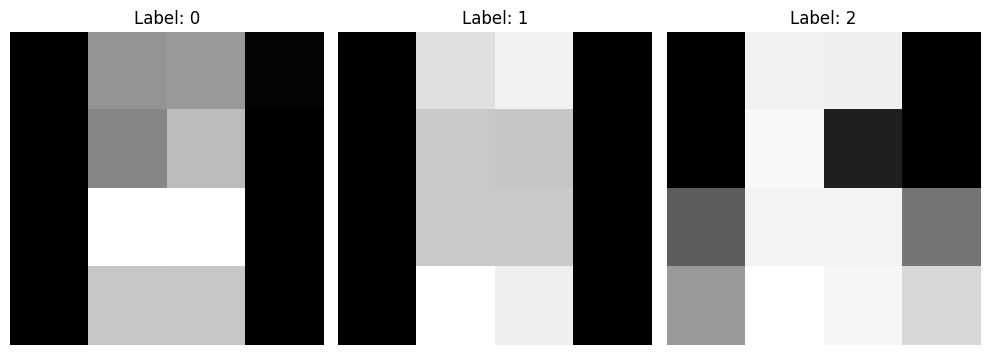

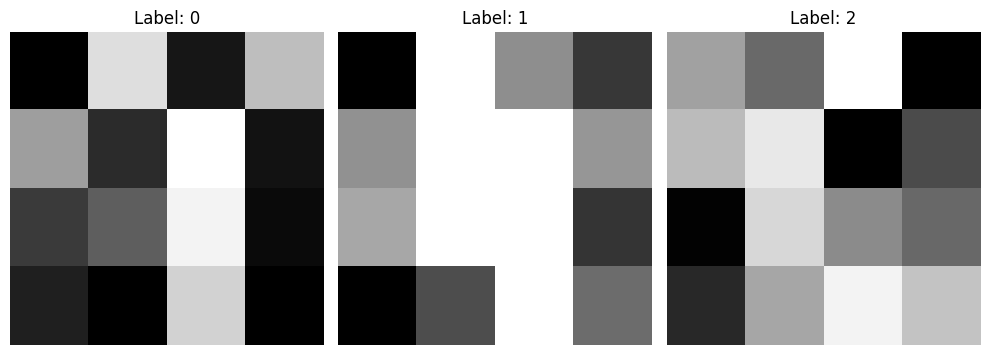

In [ ]:
# Create new resized input images
def resize_images_tf(images, new_size=(4, 4)):
    images = tf.expand_dims(images, axis=-1)  # Add the channel dimension (1 for grayscale)
    resized_images = tf.image.resize(images, new_size)
    return resized_images

# Resize and show the clean and noisy 4x4 images
train_data_clean_4x4 = resize_images_tf(train_images_subset, new_size=(4, 4))
test_data_clean_4x4 = resize_images_tf(test_images_subset, new_size=(4, 4))
display_images(train_data_clean_4x4, train_labels_subset, num_images=3)

train_data_noisy_4x4 = add_gaussian_noise(train_data_clean_4x4, severity=5)
test_data_noisy_4x4 = add_gaussian_noise(test_data_clean_4x4, severity=5)
display_images(train_data_noisy_4x4, train_labels_subset, num_images=3)

In [ ]:
# Function for creating CCNN model for 4x4 images
# This model is a scaled down version of the earlier model,
# removing dropout and a smaller kernel size to accommodate for the smaller input size
def create_model_4x4():
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(filters=4, kernel_size=(2, 2), activation='tanh', input_shape=(4, 4, 1)))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))

    # Block 2
    model.add(layers.Conv2D(filters=8, kernel_size=(2, 2), activation='tanh'))

    # Block 3
    model.add(layers.Conv2D(filters=8, kernel_size=(1, 1), activation='tanh'))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    model.summary()

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
# Create the clean model for the scaled down dataset
# For the subsampled data we will use batch size 32 since the dataset is significantly smaller
clean_model_4x4 = create_model_4x4()
history_clean_4x4 = clean_model_4x4.fit(train_data_clean_4x4,
                                train_labels_subset,
                                epochs=10,
                                batch_size=32,
                                validation_data=(test_data_clean_4x4, test_labels_subset)
                                )

# Evaluate on clean test data
test_loss_clean_4x4, test_acc_clean_4x4 = clean_model_4x4.evaluate(test_data_clean_4x4, test_labels_subset, verbose=2)
print(f"Clean 4x4 Data - Test Accuracy: {test_acc_clean_4x4:.4f}, Test Loss: {test_loss_clean_4x4:.4f}")
print(f"Clean 4x4 Data - Training Accuracy: {history_clean_4x4.history['accuracy'][-1]:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 3, 3, 4)             │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 2, 2, 4)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1, 1, 8)             │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 8)             │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 318 (1.24 KB)

 Trainable params: 318 (1.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1668 - loss: 2.3592 - val_accuracy: 0.2180 - val_loss: 2.1573
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2148 - loss: 2.0861 - val_accuracy: 0.2680 - val_loss: 1.9449
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2798 - loss: 1.9048 - val_accuracy: 0.2980 - val_loss: 1.8360
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3336 - loss: 1.7868 - val_accuracy: 0.3740 - val_loss: 1.7537
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3749 - loss: 1.7317 - val_accuracy: 0.3780 - val_loss: 1.7030
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3892 - loss: 1.6921 - val_accuracy: 0.3950 - val_loss: 1.6686
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3901 - loss: 1.6540 - val_accuracy: 0.4040 - val_loss: 1.6396
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4251 - loss: 1.6346 - val_accuracy: 0

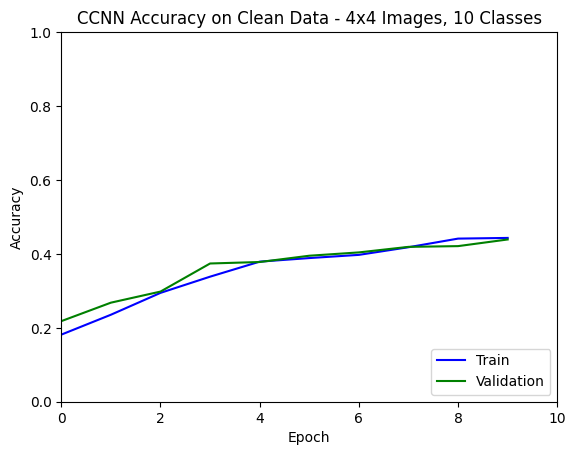

In [ ]:
plot_metrics(history_clean_4x4, "accuracy", "CCNN Accuracy on Clean Data - 4x4 Images, 10 Classes")

In [ ]:
# Create the noisy model for the scaled down dataset
noisy_model_4x4 = create_model_4x4()
history_noisy_4x4 = noisy_model_4x4.fit(train_data_noisy_4x4,
                                train_labels_subset,
                                epochs=10,
                                batch_size=32,
                                validation_data=(test_data_noisy_4x4, test_labels_subset)
                                )

# Evaluate on noisy test data
test_loss_noisy_4x4, test_acc_noisy_4x4 = noisy_model_4x4.evaluate(test_data_noisy_4x4, test_labels_subset, verbose=2)
print(f"Noisy 4x4 Data - Test Accuracy: {test_acc_noisy_4x4:.4f}, Test Loss: {test_loss_noisy_4x4:.4f}")
print(f"Noisy 4x4 Data - Training Accuracy: {history_noisy_4x4.history['accuracy'][-1]:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 4)             │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 2, 2, 4)             │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 8)             │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 1, 1, 8)             │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 318 (1.24 KB)

 Trainable params: 318 (1.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.1343 - loss: 2.3520 - val_accuracy: 0.1940 - val_loss: 2.2138
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2161 - loss: 2.1521 - val_accuracy: 0.2530 - val_loss: 2.0402
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2478 - loss: 2.0104 - val_accuracy: 0.2610 - val_loss: 1.9858
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2623 - loss: 1.9704 - val_accuracy: 0.2820 - val_loss: 1.9571
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2638 - loss: 1.9425 - val_accuracy: 0.2760 - val_loss: 1.9304
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2748 - loss: 1.8994 - val_accuracy: 0.2830 - val_loss: 1.9118
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2900 - loss: 1.8867 - val_accuracy: 0.3110 - val_loss: 1.8950
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2911 - loss: 1.8768 - val_accuracy: 0

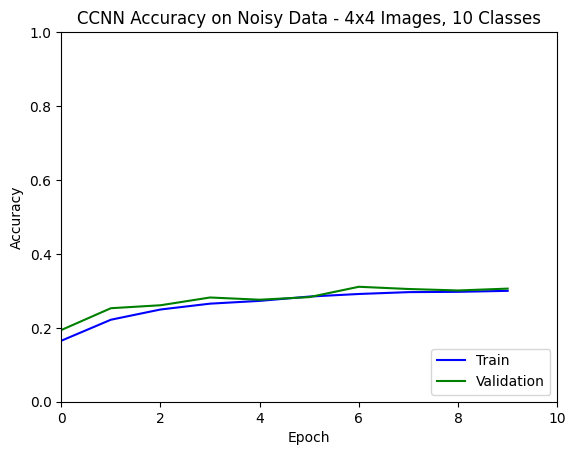

In [ ]:
plot_metrics(history_noisy_4x4, "accuracy", "CCNN Accuracy on Noisy Data - 4x4 Images, 10 Classes")

In [ ]:
#Comparing other performance metrics
y_true = test_labels_subset

# Clean predictions
y_pred_clean_4x4 = clean_model_4x4.predict(test_data_clean_4x4)
y_pred_clean_4x4 = np.argmax(y_pred_clean_4x4, axis=-1)  # Convert probabilities to class indices

# Noisy predictions
y_pred_noisy_4x4 = noisy_model_4x4.predict(test_data_noisy_4x4)
y_pred_noisy_4x4 = np.argmax(y_pred_noisy_4x4, axis=-1)  # Convert probabilities to class indices

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
# Clean metrics
accuracy_clean_4x4 = accuracy_score(y_true, y_pred_clean_4x4)
precision_clean_4x4 = precision_score(y_true, y_pred_clean_4x4, average='weighted')
recall_clean_4x4 = recall_score(y_true, y_pred_clean_4x4, average='weighted')
f1_clean_4x4 = f1_score(y_true, y_pred_clean_4x4, average='weighted')

print("\nClean Data Metrics:")
print(f"Accuracy: {accuracy_clean_4x4:.4f}")
print(f"Precision: {precision_clean_4x4:.4f}")
print(f"Recall: {recall_clean_4x4:.4f}")
print(f"F1 Score: {f1_clean_4x4:.4f}")


Clean Data Metrics:
Accuracy: 0.4390
Precision: 0.4174
Recall: 0.4390
F1 Score: 0.4023


In [ ]:
# Noisy metrics
accuracy_noisy_4x4 = accuracy_score(y_true, y_pred_noisy_4x4)
precision_noisy_4x4 = precision_score(y_true, y_pred_noisy_4x4, average='weighted')
recall_noisy_4x4 = recall_score(y_true, y_pred_noisy_4x4, average='weighted')
f1_noisy_4x4 = f1_score(y_true, y_pred_noisy_4x4, average='weighted')

print("\nNoisy Data Metrics:")
print(f"Accuracy: {accuracy_noisy_4x4:.4f}")
print(f"Precision: {precision_noisy_4x4:.4f}")
print(f"Recall: {recall_noisy_4x4:.4f}")
print(f"F1 Score: {f1_noisy_4x4:.4f}")


Noisy Data Metrics:
Accuracy: 0.3060
Precision: 0.2532
Recall: 0.3060
F1 Score: 0.2600


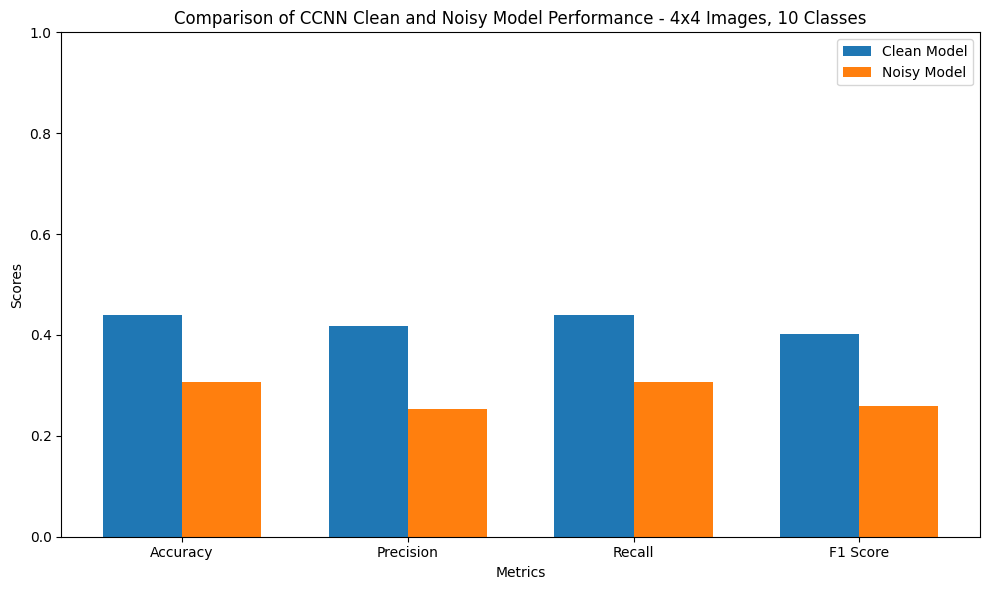

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
clean_values = [accuracy_clean_4x4, precision_clean_4x4, recall_clean_4x4, f1_clean_4x4]
noisy_values = [accuracy_noisy_4x4, precision_noisy_4x4, recall_noisy_4x4, f1_noisy_4x4]

x = np.arange(len(metrics))  # The label locations
width = 0.35  # The width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, clean_values, width, label='Clean Model')
rects2 = ax.bar(x + width/2, noisy_values, width, label='Noisy Model')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of CCNN Clean and Noisy Model Performance - 4x4 Images, 10 Classes')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)  # Fixed y-axis range from 0 to 1
plt.tight_layout()
plt.show()



---
The next section provides a different comparison with the binary classification QCNN model, where two classes are selected and again scaled down to 4x4. This model is simplified to have a minimal number of trainable parameters to be a fair comparison with the binary QCNN model.


---




In [ ]:
# Select only T-shirt/top (0) and Trouser (1)
classes_to_keep = [0, 1]
train_filter = np.isin(train_labels, classes_to_keep)
train_data_bin = train_data_clean[train_filter]
train_labels_bin = train_labels[train_filter]

test_filter = np.isin(test_labels, classes_to_keep)
test_data_bin = test_data_clean[test_filter]
test_labels_bin = test_labels[test_filter]

print("Binary training data shape:", train_data_bin.shape)
print("Binary test data shape:", test_data_bin.shape)

# Convert the images in these classes to 4x4 pixels
train_binary_4x4 = resize_images_tf(train_data_bin, new_size=(4,4))
test_binary_4x4 = resize_images_tf(test_data_bin, new_size=(4,4))

Binary training data shape: (12000, 28, 28)
Binary test data shape: (2000, 28, 28)


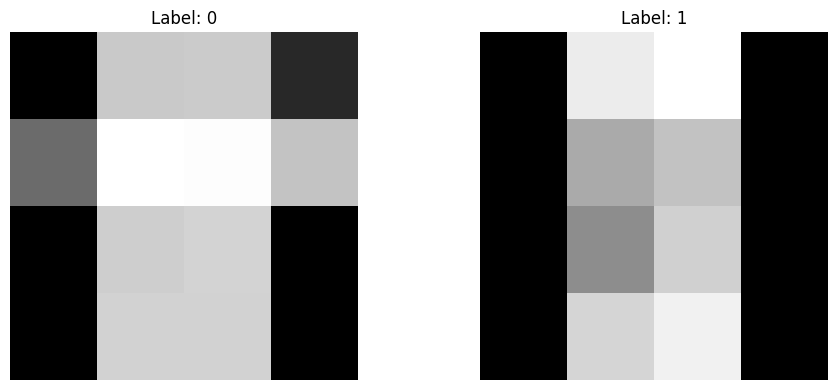

In [ ]:
def display_images_bin(images, labels, num_images=3):

    selected_classes = np.unique(labels)[:num_images]

    # Empty lists to store images and labels
    selected_images = []
    selected_labels = []

    # Select one image per selected class
    for class_label in selected_classes:
        class_indices = np.where(labels == class_label)[0]
        selected_images.append(images[class_indices[0]])  # Choose first image from the class
        selected_labels.append(labels[class_indices[0]])  # Store the corresponding label

    # Convert the list back to arrays
    selected_images = np.array(selected_images)
    selected_labels = np.array(selected_labels)

    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 4))

    for i, ax in enumerate(axes):
        ax.imshow(selected_images[i].squeeze(), cmap='gray')  # Remove the channel dimension
        ax.set_title(f'Label: {selected_labels[i]}')
        ax.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()


display_images_bin(train_binary_4x4, train_labels_bin, num_images=2)

In [ ]:
# Creating a model for the binary classification tasks
# Very simple model to have limited number of trainable parameters for fair comparison with QCNN
def create_binary_model():
    model = models.Sequential()
    model.add(layers.Conv2D(4, (2,2), activation='relu', input_shape=(4,4,1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(2))
    model.add(layers.Dense(1))

    model.summary()

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
clean_model_bin = create_binary_model()
history_bin = clean_model_bin.fit(train_binary_4x4,
                                  train_labels_bin,
                                  epochs=10,
                                  batch_size=128,
                                  validation_data=(test_binary_4x4, test_labels_bin))

# Evaluate on clean test data
test_loss_clean_bin, test_acc_clean_bin = clean_model_bin.evaluate(test_binary_4x4, test_labels_bin, verbose=2)
print(f"Clean Binary Data - Test Accuracy: {test_acc_clean_bin:.4f}, Test Loss: {test_loss_clean_bin:.4f}")
print(f"Clean Binary Data - Training Accuracy: {history_bin.history['accuracy'][-1]:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 3, 3, 4)             │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 36)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │              74 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4979 - loss: 7.7081 - val_accuracy: 0.4995 - val_loss: 7.0760
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4991 - loss: 6.6289 - val_accuracy: 0.4970 - val_loss: 1.6746
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4800 - loss: 1.1098 - val_accuracy: 0.4790 - val_loss: 0.7239
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4970 - loss: 0.6926 - val_accuracy: 0.5485 - val_loss: 0.6732
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5744 - loss: 0.6354 - val_accuracy: 0.6070 - val_loss: 0.6432
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6381 - loss: 0.6114 - val_accuracy: 0.6445 - val_loss: 0.6270
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6702 - loss: 0.5955 - val_accuracy: 0.6740 - val_loss: 0.6210
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6930 - loss: 0.5877 - val_accuracy: 0.6860 - val_loss:

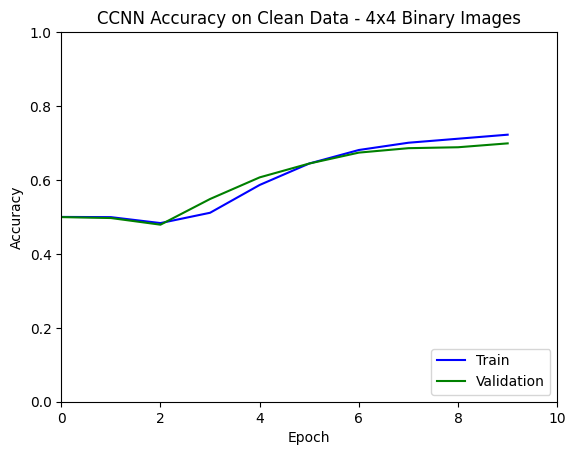

In [ ]:
plot_metrics(history_bin, "accuracy", "CCNN Accuracy on Clean Data - 4x4 Binary Images")

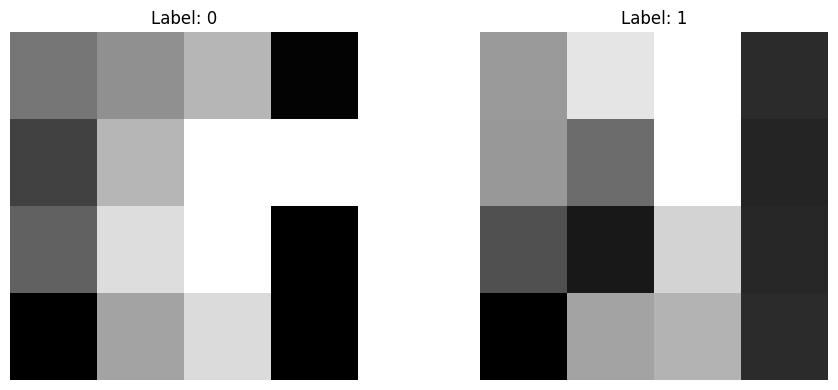

In [ ]:
# Now adding noise to the binary images
train_data_noisy_bin = add_gaussian_noise(train_binary_4x4, severity=5)
test_data_noisy_bin = add_gaussian_noise(test_binary_4x4, severity=5)

display_images_bin(train_data_noisy_bin, train_labels_bin, num_images=2)

In [ ]:
noisy_model_bin = create_binary_model()

history_noisy_bin = noisy_model_bin.fit(train_data_noisy_bin,
                                        train_labels_bin,
                                        epochs=10,
                                        batch_size=128,
                                        validation_data=(test_data_noisy_bin, test_labels_bin))

# Evaluate on nosiy test data
test_loss_noisy_bin, test_acc_noisy_bin = noisy_model_bin.evaluate(test_data_noisy_bin, test_labels_bin, verbose=2)
print(f"Noisy Binary Data - Test Accuracy: {test_acc_noisy_bin:.4f}, Test Loss: {test_loss_noisy_bin:.4f}")
print(f"Noisy Binary Data - Training Accuracy: {history_noisy_bin.history['accuracy'][-1]:.4f}")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 3, 3, 4)             │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 36)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │              74 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4999 - loss: 3.0969 - val_accuracy: 0.4985 - val_loss: 0.8758
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5006 - loss: 0.8415 - val_accuracy: 0.4880 - val_loss: 0.7794
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4894 - loss: 0.7749 - val_accuracy: 0.4945 - val_loss: 0.7387
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5042 - loss: 0.7396 - val_accuracy: 0.5180 - val_loss: 0.7211
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5215 - loss: 0.7155 - val_accuracy: 0.5280 - val_loss: 0.7098
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5253 - loss: 0.7078 - val_accuracy: 0.5355 - val_loss: 0.6997
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5324 - loss: 0.7009 - val_accuracy: 0.5475 - val_loss: 0.6904
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5541 - loss: 0.6869 - val_accuracy: 0.5555 - val_loss:

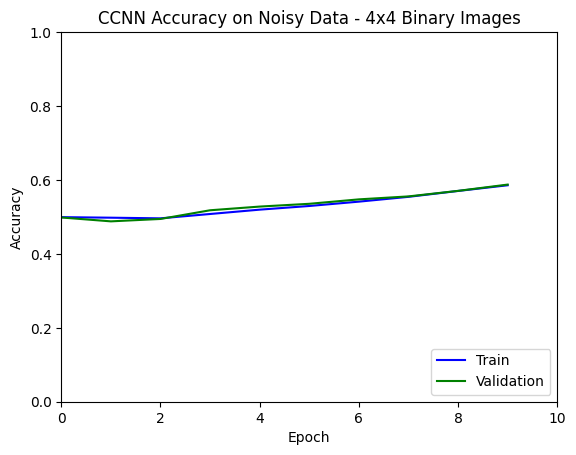

In [ ]:
plot_metrics(history_noisy_bin, "accuracy", "CCNN Accuracy on Noisy Data - 4x4 Binary Images")

In [ ]:
# Comparing other performance metrics
y_true = test_labels_bin

# Clean predictions
y_pred_clean_bin = clean_model_bin.predict(test_binary_4x4)
y_pred_clean_bin = (y_pred_clean_bin > 0.5).astype(int)  # Convert probabilities to binary classes

# Noisy predictions
y_pred_noisy_bin = noisy_model_bin.predict(test_data_noisy_bin)
y_pred_noisy_bin = (y_pred_noisy_bin > 0.5).astype(int)  # Convert probabilities to binary classes

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Clean metrics
accuracy_clean_bin = accuracy_score(y_true, y_pred_clean_bin)
precision_clean_bin = precision_score(y_true, y_pred_clean_bin, average='weighted')
recall_clean_bin = recall_score(y_true, y_pred_clean_bin, average='weighted')
f1_clean_bin = f1_score(y_true, y_pred_clean_bin, average='weighted')

print("\nClean Data Metrics:")
print(f"Accuracy: {accuracy_clean_bin:.4f}")
print(f"Precision: {precision_clean_bin:.4f}")
print(f"Recall: {recall_clean_bin:.4f}")
print(f"F1 Score: {f1_clean_bin:.4f}")


Clean Data Metrics:
Accuracy: 0.6990
Precision: 0.7060
Recall: 0.6990
F1 Score: 0.6964


In [ ]:
# Noisy metrics
accuracy_noisy_bin = accuracy_score(y_true, y_pred_noisy_bin)
precision_noisy_bin = precision_score(y_true, y_pred_noisy_bin, average='weighted')
recall_noisy_bin = recall_score(y_true, y_pred_noisy_bin, average='weighted')
f1_noisy_bin = f1_score(y_true, y_pred_noisy_bin, average='weighted')

print("\nNoisy Data Metrics:")
print(f"Accuracy: {accuracy_noisy_bin:.4f}")
print(f"Precision: {precision_noisy_bin:.4f}")
print(f"Recall: {recall_noisy_bin:.4f}")
print(f"F1 Score: {f1_noisy_bin:.4f}")


Noisy Data Metrics:
Accuracy: 0.5875
Precision: 0.5878
Recall: 0.5875
F1 Score: 0.5872


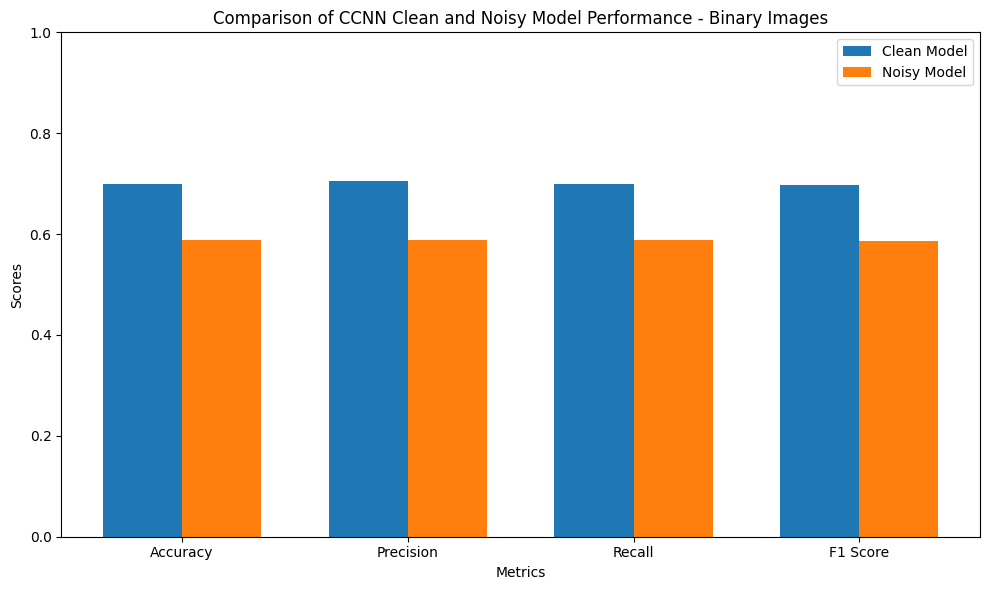

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
clean_values = [accuracy_clean_bin, precision_clean_bin, recall_clean_bin, f1_clean_bin]
noisy_values = [accuracy_noisy_bin, precision_noisy_bin, recall_noisy_bin, f1_noisy_bin]

x = np.arange(len(metrics))  # The label locations
width = 0.35  # The width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, clean_values, width, label='Clean Model')
rects2 = ax.bar(x + width/2, noisy_values, width, label='Noisy Model')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of CCNN Clean and Noisy Model Performance - Binary Images')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)  # Fixed y-axis range from 0 to 1
plt.tight_layout()
plt.show()